Описание проекта
==

Необходимо провести анализ данных о продажах игр - выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Описание данных:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


# Содержание
1. [Чтение данных](#read_data)
2. [Подготовка данных](#preparation)
3. [Исследовательский анализ данных](#research)
4. [Портрет покупателя](#customer)
5. [Проверка гипотез](#hypothesis)
6. [Вывод](#conclusion)

# Чтение данных<a name="read_data"></a>

In [1]:
#импорт библиотек и знакомство с данными
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
%matplotlib inline

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


**Вывод**

В нашем датасете собраны данные по играм, выпущенным с 1980 по 2016 год.
В ходе проверки данных были выявлены следующие проблемы: 
* названия столбцов записаны в разном регистре
* неверный тип данных в столбцах: Year_of_Release(должен быть целым числом) и User_Score(должен быть числом)
* пропуски в названии игры, годах выпуска, рейтингах

# Подготовка данных <a name="preparation"></a>

In [5]:
#приведем названия столбцов к нижнему реигстру:
data.columns = data.columns.str.lower()

In [6]:
#удалим строки с отсутсвующим годом выпуска:
data.dropna(subset=['year_of_release'], inplace=True)

In [7]:
#преобразуем тип данных в столбце с годом выпуска игры:
data['year_of_release'] = data['year_of_release'].astype('int32')

In [8]:
#подсчитаем значения рейтингов, оставленных пользователями:
data['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1         2
0.3       2
0.2       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

В нашем датасете очень много пропусков в оценках игр - как критиками и ESRB, так и пользователями. Возможно, речь идет о каких-то не самых популярных играх, и их оценки просто не проводилось. Аббревиатура "tbd" расшифровывается как "To Be Determined", то есть "Будет определено". Обычно такое обозначение используется для игр, которые еще не вышли. Поскольку такое значение оказалось в столбце намеренно, стоит заменить его на NaN.

In [9]:
#заменим тип данных в столбце с оценкой пользователей:
data['user_score'] = data['user_score'].replace('tbd', np.nan, regex=True)
#переведем столбец с оценками пользователей в числовой тип:
data['user_score'] = pd.to_numeric(data['user_score'])

In [10]:
#выведем строки с пропусками в названии игры:
data[data['name'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [11]:
#поскольку у данных игр практически отсуствуют продажи, их оценки никем не проводилось, 
#а год выпуска довольно старый и для анализа не пригодится, то можно эти строки удалить:
data.dropna(subset=['name'], inplace=True)

In [12]:
#выведем общую информацию о датасете еще раз:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


In [13]:
#создадим столбец с выручкой по всем регионам:
data['revenue'] = (
    data['na_sales'] +
    data['eu_sales'] +
    data['jp_sales'] +
    data['other_sales'])

Выявленные проблемы в данных исправлены:
* названия столбцов записаны в нижнем регистре
* переведены типы данных в столбцах 'year_of_release' и 'user_score'
* удалены строки с отсуствующим годом выпуска и названием игры.

Пропуски с рейтингами игр стоит заполнить заглушкой - т.к. рейтинг ESRB использвуется только для США и Канады, для остальных стран он не актуален (что может быть причиной наличия пропусков).

In [15]:
#заменим пропуски:
data['rating'] = data['rating'].fillna('QQQ')

# Исследовательский анализ данных <a name="research"></a>

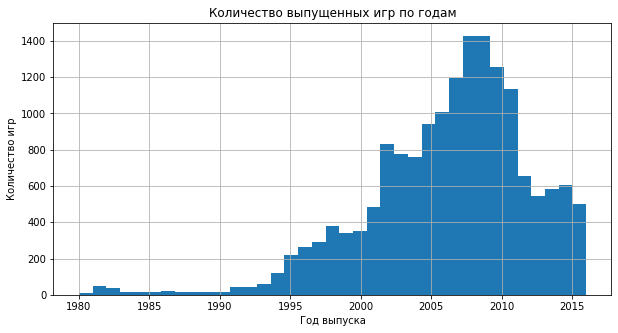

In [16]:
#проверим распределение выпущенных игр по годам:
data['year_of_release'].hist(bins=37, figsize=(10, 5))
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр');

Основная масса игр была выпущена с 2002 года. После 2008 года это количество начинает падать. 

Поскольку рынок компьютерных игр довольно динамичен, для анализа понадобятся только несколько последних лет. Проверим, какие платформы пользовались популярностью в разное время, а также выручку по самым популярным платформам:

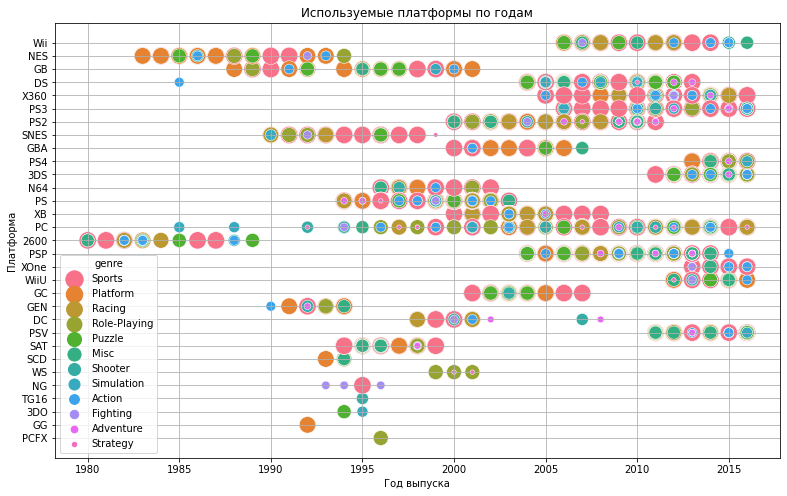

In [17]:
#изучим, какие платформы в какое время использовались:
plt.figure(figsize=(13,8))
sns.scatterplot(data=data,\
                x='year_of_release',\
                y='platform',\
                hue='genre',\
                size='genre',\
                sizes=(20, 300))
plt.grid()
plt.xlabel('Год выпуска')
plt.ylabel('Платформа')
plt.title('Используемые платформы по годам');

Из диаграммы видно, что некоторые платформы устарели и больше не используются. На 2016 год актуальны 9 платформ: Wii, X360, PS3, GBA, PS4, PC, Xone, WiiU и PSV.

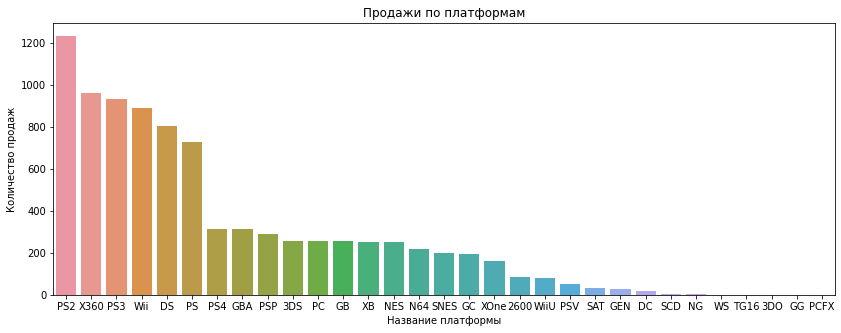

In [18]:
#рассмотрим продажи игр на разных платформах:
platform_sales = data.pivot_table(
    index='platform', 
    values='revenue', 
    aggfunc='sum').sort_values(by='revenue', ascending=False)

plt.figure(figsize=(14, 5))
sns.barplot(x=platform_sales.index,
            y=platform_sales['revenue'])
plt.title('Продажи по платформам')
plt.xlabel('Название платформы')
plt.ylabel('Количество продаж');

Лидерами по продажам за весь период являются 6 платформ: PS2, X360, PS3, Wii, DS, PS.

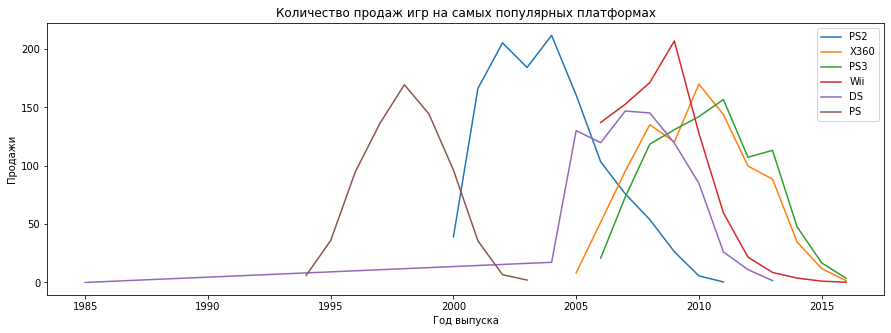

In [19]:
#рассмотрим количество продаж на 6 самых популярных платформах.
#напишем функцию, возвращающую сводную таблицу для построения графика:
def popular_sales(platform, data):
    slicee = data[data['platform'] == platform]
    total = slicee.pivot_table(index='year_of_release', 
                               values='revenue', 
                               aggfunc='sum').sort_values('year_of_release', ascending=False)
    return total

#создадим сводную таблицу с самыми популярными платформами и их общими продажами:
top6 = data.pivot_table(
    index='platform', 
    values='revenue', 
    aggfunc='sum').sort_values(by='revenue', ascending=False).head(6)
top6 = top6.reset_index().rename_axis(None, axis=1)

#посмотрим график продаж:
plt.figure(figsize=(15,5))
plt.title('Количество продаж игр на самых популярных платформах')
plt.xlabel('Год выпуска')
plt.ylabel('Продажи')

for i in list(top6['platform']):
    sns.lineplot(data=popular_sales(i,data)['revenue'], label=i)
    plt.legend()

Из графика видно, что срок жизни самых популярных платформ составляет около 10 лет. Пик продаж практически у всех приходится на середину этого срока. Исключение здесь - платформа Wii: у них были высокие продажи с самого первого года существования платфомы, а на четвертый год пошел резкий спад.

Платформа DS была выпущена в 2004 году, но в датасет попала срока, где указан 1985 год. Скорее всего, здесь есть какая-то ошибка в данных - либо неправильно указана платформа, либо год выпуска игры.

In [20]:
data.query('platform == "DS"').sort_values(by='year_of_release').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,revenue
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.00,0.00,0.02,0.0,NaN,NaN,QQQ,0.02
13463,Cocoto Kart Racer,DS,2004,Racing,0.04,0.00,0.00,0.0,NaN,NaN,E,0.04
11517,Kenshuui Tendo Dokuta,DS,2004,Simulation,0.00,0.00,0.08,0.0,NaN,NaN,QQQ,0.08
4421,The Urbz: Sims in the City (all regions sales),DS,2004,Simulation,0.40,0.01,0.02,0.0,NaN,NaN,QQQ,0.43
7902,Daigasso! Band Brothers,DS,2004,Misc,0.00,0.00,0.19,0.0,NaN,NaN,QQQ,0.19


In [21]:
#рассмотрим срок жизни различных платформ:
durability = (data.loc[:,['year_of_release', 'platform']]
        .drop_duplicates()
        .pivot_table(index=['platform'], values='year_of_release', aggfunc='count')
       )
durability.sort_values(by='year_of_release', ascending=False)

,year_of_release
platform,
PC,26
GB,13
NES,12
X360,12
PSP,12
PS2,12
Wii,11
DS,11
PS3,11


In [22]:
durability.describe()

,year_of_release
count,31.000000
mean,7.677419
std,5.081910
min,1.000000
25%,4.000000
50%,7.000000
75%,11.000000
max,26.000000


В среднем срок жизни игровой платформы составляет около 7 лет, хотя среди самых популярных этот срок составляет 10 лет. Здесь на среднее влияют некоторые платформы, которые быстро перестали использоваться - таких около 1/4 от общего количества.

Исходя из предыдущих графиков и выводов, для анализа возьмем период с 2012 по 2016 год. Этих данных должно быть достаточно для выявления каких-либо трендов. Более ранний период брать не стоит, т.к. к анализу добавляются неактуальные платформы, а те, которые нам нужны, в то время еще не использовались.

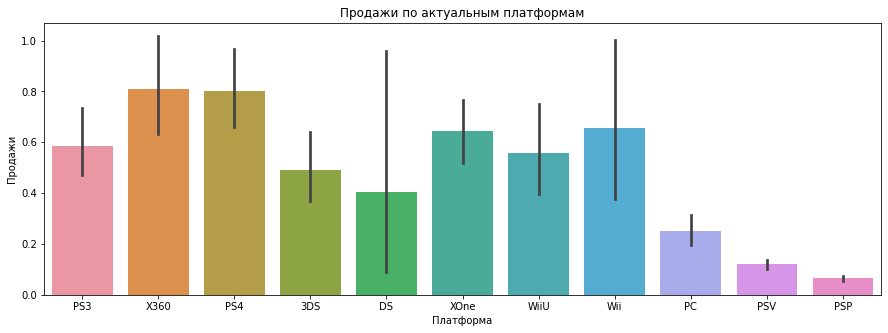

In [23]:
#рассмотрим продажи по актуальным платформам.
#PSP и DS из анализа исключим, т.к. данные платформы в 2016 году уже не использовались.
data_actual = data.query('year_of_release >= 2012')
plt.figure(figsize=(15,5))
sns.barplot(data=data_actual, x='platform', y='revenue')
plt.title('Продажи по актуальным платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи');

По продажам в последние года лидируют X360 и PS4. Помимо них есть еще три потенциально прибыльные платформы: PS3, XOne, Wii. Проверим продажи по этим пяти лидерам в разбике на года.

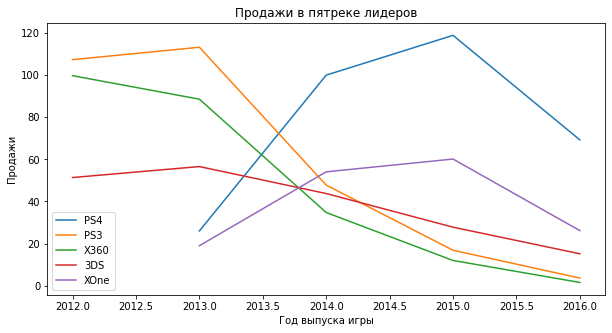

In [24]:
#напишем функцию, возвращающую сводную таблицу по каждой платформе:
def platform_revenue(platform, data):
    slicee = data_actual[data_actual['platform'] == platform]
    total = slicee.pivot_table(index='year_of_release', 
                               values='revenue', 
                               aggfunc='sum').sort_values('year_of_release', ascending=False)
    return total

#сделаем сводную таблицу по 5 самым популярным платформам и их общими продажами:
top5 = data_actual.pivot_table(
    index='platform', 
    values='revenue', 
    aggfunc='sum').sort_values(by='revenue', ascending=False).head()
top5 = top5.reset_index().rename_axis(None, axis=1)

#построим график:
plt.figure(figsize=(10,5))
plt.title('Продажи в пятреке лидеров')
plt.xlabel('Год выпуска игры')
plt.ylabel('Продажи')

for j in list(top5['platform']):
    sns.lineplot(data=platform_revenue(j, data_actual)['revenue'], label=j)
    plt.legend()

На графике видно, что у всех потенциально прибыльных игровых платформ наблюдается падение продаж. Тем не менее, игры на PS4 все еще довольно неплохо продаются.

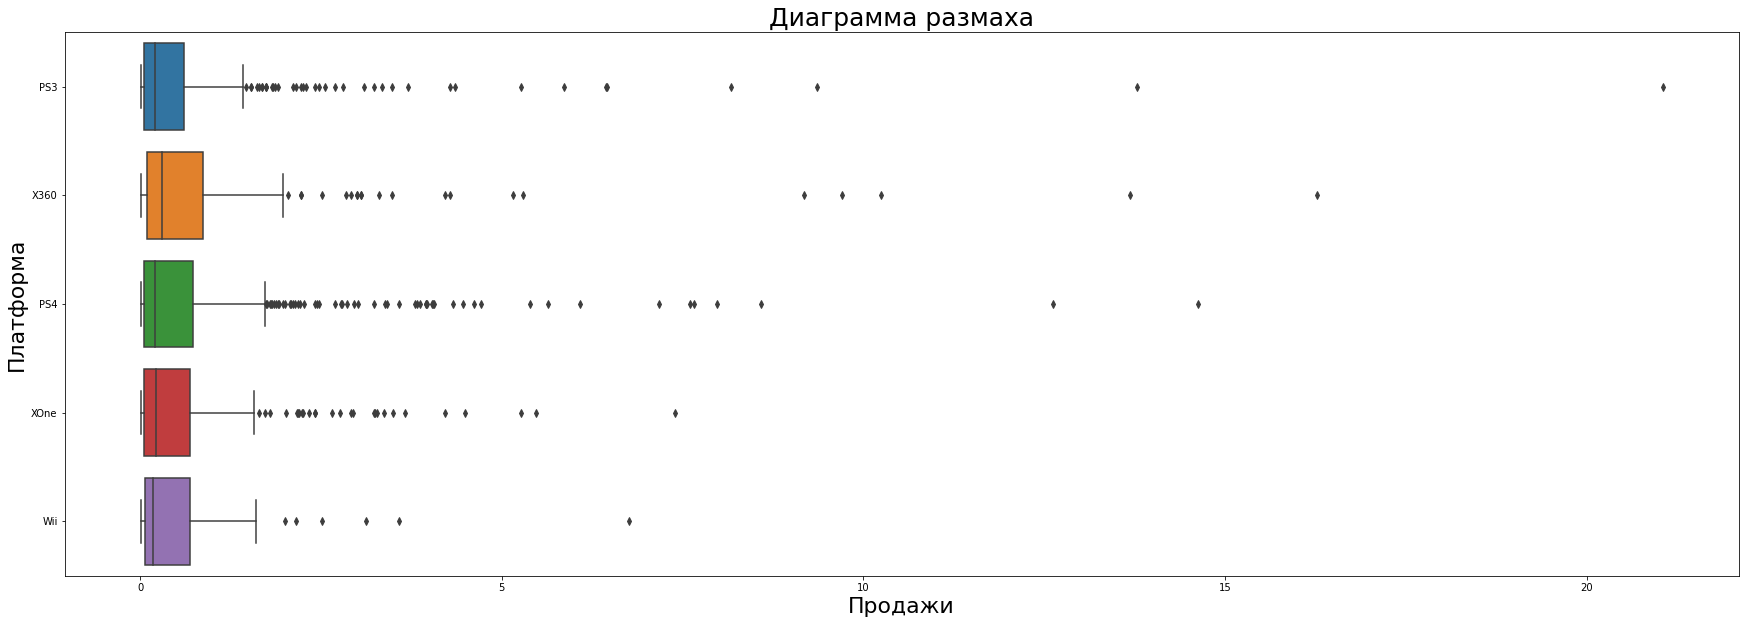

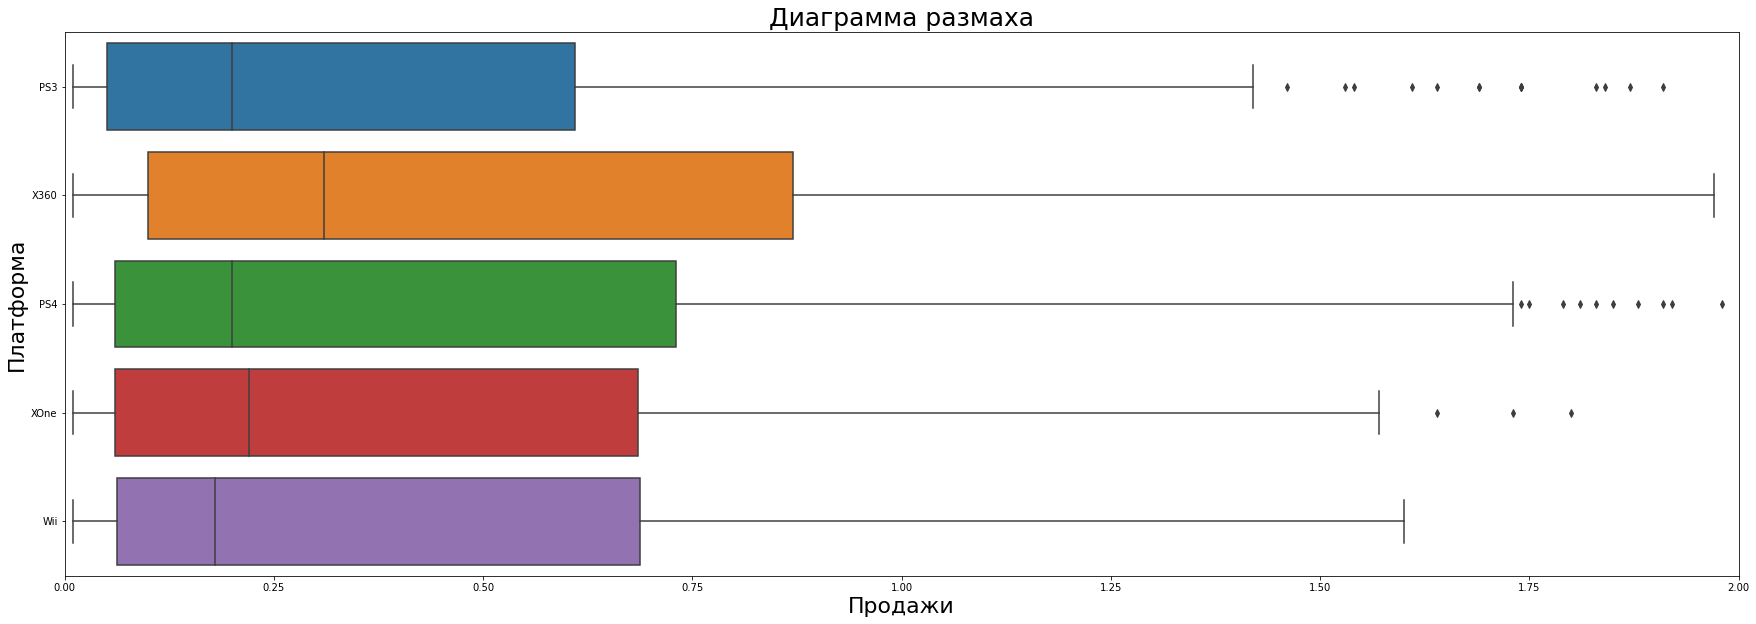

In [25]:
#построим диаграмму размаха по выручке на каждой из 5 популярных платформ:
plt.figure(figsize=(30,10))
sns.boxplot(data=data_actual.query('platform == "X360"\
                                   or platform == "PS4" \
                                   or platform == "PS3"\
                                   or platform == "XOne"\
                                   or platform == "Wii"'), x='revenue', y='platform')
plt.title('Диаграмма размаха', fontsize=25)
plt.xlabel('Продажи', fontsize=22)
plt.ylabel('Платформа',fontsize=22)
plt.show();

#построим диаграмму размаха по выручке на каждой из 5 популярных платформ c ограничением выбросов:
plt.figure(figsize=(30,10))
sns.boxplot(data=data_actual.query('platform == "X360"\
                                   or platform == "PS4" \
                                   or platform == "PS3"\
                                   or platform == "XOne"\
                                   or platform == "Wii"'), x='revenue', y='platform')
plt.title('Диаграмма размаха', fontsize=25)
plt.xlabel('Продажи', fontsize=22)
plt.ylabel('Платформа',fontsize=22)
plt.xlim(0, 2);

Как видно из диаграмм, в продажах по каждой из 5 платформ есть выбросы. Но это имеет место быть: отдельные игры могли принести на порядок больше продаж.

In [26]:
#проверим влияние отзывов на продажи. Для анализа возьмем самую популярную из пятерки платформу - X360:
data_360 = data_actual.query('platform == "X360"')

0.3605734888507336

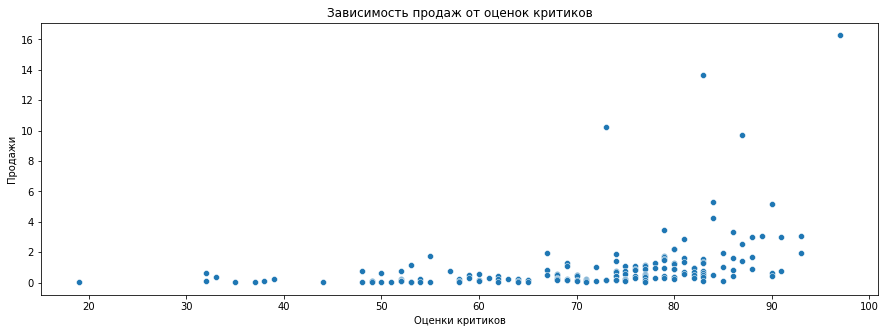

In [27]:
#отзывы критиков
plt.figure(figsize=(15, 5))
sns.scatterplot(data=data_360, x='critic_score', y='revenue')
plt.title('Зависимость продаж от оценок критиков')
plt.xlabel('Оценки критиков')
plt.ylabel('Продажи');
data_360['critic_score'].corr(data_360['revenue'])

0.006163978646213326

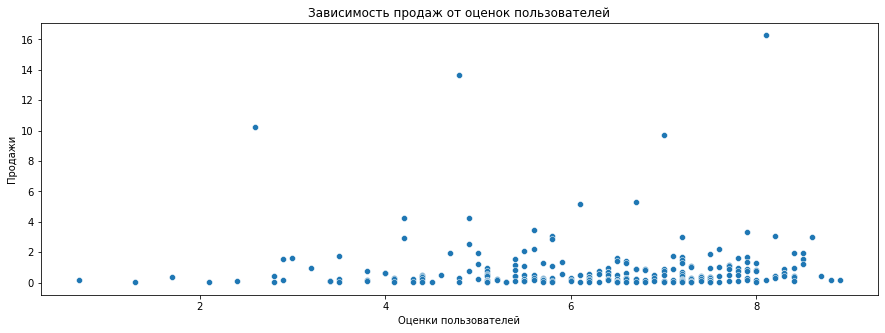

In [28]:
#отзывы пользователей
plt.figure(figsize=(15, 5))
sns.scatterplot(data=data_360, x='user_score', y='revenue')
plt.title('Зависимость продаж от оценок пользователей')
plt.xlabel('Оценки пользователей')
plt.ylabel('Продажи');
data_360['user_score'].corr(data_360['revenue'])

Зависимость продаж от оценок критиков слабая: с увеличением оценки продажи растут, но очень мало. Зависимости продаж от оценок пользователей в данном случае нет.

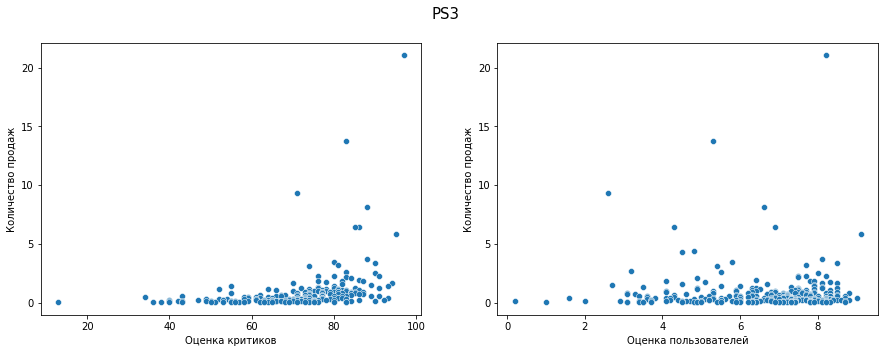

'Коэффециент корреляции оценок критиков и продаж'

0.3314972592629587

'Коэффециент корреляции оценок пользователей и продаж'

-0.005143522887113828

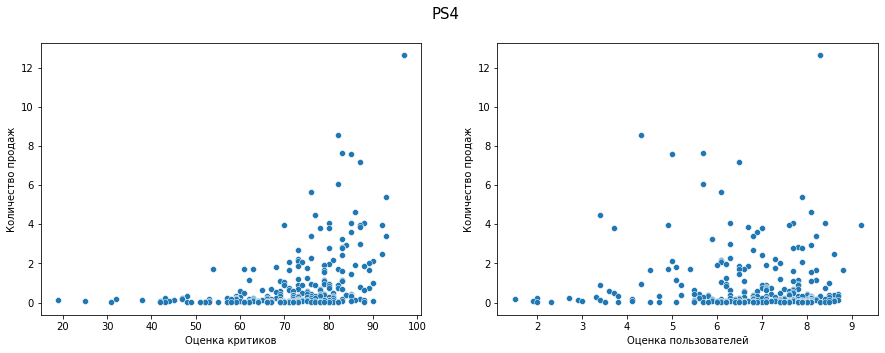

'Коэффециент корреляции оценок критиков и продаж'

0.40656790206178095

'Коэффециент корреляции оценок пользователей и продаж'

-0.031957110204556376

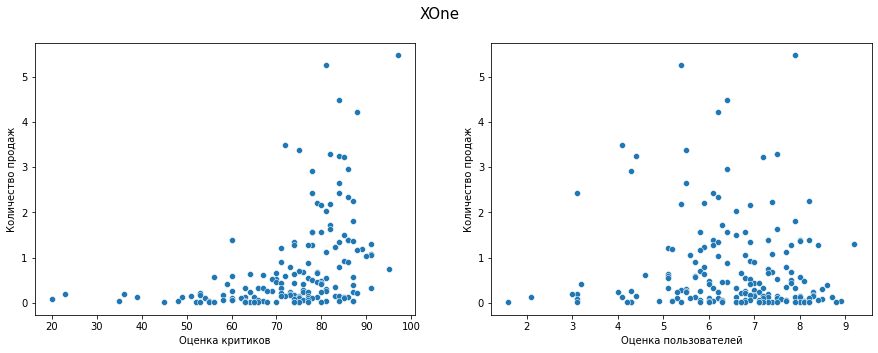

'Коэффециент корреляции оценок критиков и продаж'

0.4169983280084017

'Коэффециент корреляции оценок пользователей и продаж'

-0.06892505328279414

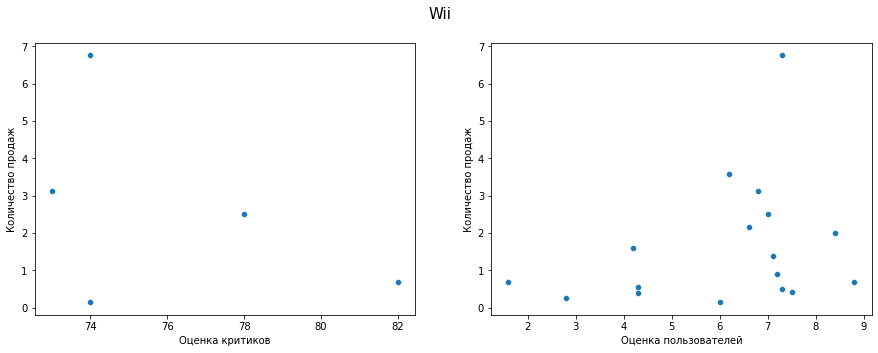

'Коэффециент корреляции оценок критиков и продаж'

-0.4243413011077494

'Коэффециент корреляции оценок пользователей и продаж'

0.29619680007479526

In [29]:
#проверим то же самое на остальных популярных платформах:
#соберем данные по оставшимся 4 платформам отдельно:
data_top = data_actual.query('platform == "PS3"\
                               or platform == "PS4"\
                               or platform == "XOne"\
                               or platform == "Wii"')

#напишем функцию для пострения графиков:
def score_dependence(platform_name):
    platform = data_top[data_top['platform'] == platform_name]
    fig, ax = plt.subplots(1 ,2, figsize=(15,5))
    sns.scatterplot(x='critic_score', y='revenue', data=platform, ax=ax[0])
    sns.scatterplot(x='user_score', y='revenue', data=platform, ax=ax[1])
    fig.suptitle(platform_name, fontsize=15)
    ax[0].set(xlabel='Оценка критиков')
    ax[1].set(xlabel='Оценка пользователей')
    ax[0].set(ylabel='Количество продаж')
    ax[1].set(ylabel='Количество продаж')
    plt.show()
    critic_corr = platform['critic_score'].corr(platform['revenue'])
    user_corr = platform['user_score'].corr(platform['revenue'])
    display('Коэффециент корреляции оценок критиков и продаж', critic_corr) 
    display('Коэффециент корреляции оценок пользователей и продаж', user_corr)

platforms_list = ['PS3', 'PS4', 'XOne', 'Wii']
for platform in platforms_list:
    score_dependence(platform)

Как видно из диаграмм, ситуация на остальных популярных платформах схожая: оценки критиков влияют на количество продаж, но довольно слабо. Оценки пользователей никакого влияния на продажи не оказывают. 

Выбивается из общей картины только платформа Wii, но это, скорее всего, связано с потерей ее популярности в период, взятый для анализа. Оценок игр в это время проводилось мало, поэтому данную выборку не стоит считать репрезентативной.

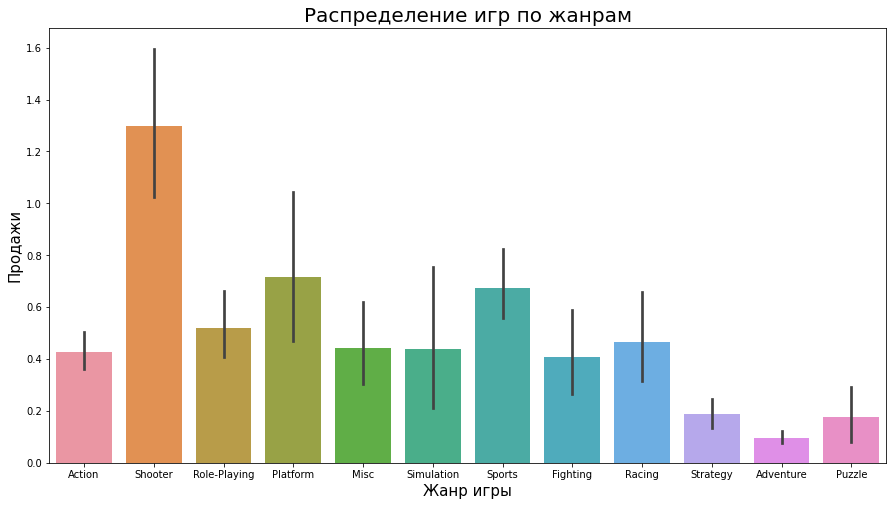

In [30]:
#проверим распределение игр по жанрам:
plt.figure(figsize=(15,8))
sns.barplot(data=data_actual, x='genre', y='revenue')
plt.title('Распределение игр по жанрам', fontsize=20)
plt.xlabel('Жанр игры', fontsize=15)
plt.ylabel('Продажи',fontsize=15);

Лучше всего продаются шутеры. Довольно неплохие продажи у игр жанров Platform и Sports. Меньше всего продаж приносят приключения и стратегии.

**Выводы**
* Количество выпускаемых игр интенсивно росло с 2002 по 2008 годы. Далее начался спад, который продолжается и к 2016 году. Лидерами по продажам за весь период являются: PS2, X360, PS3, Wii, DS, PS.
* На 2016 год актуальны 9 платформ: Wii, X360, PS3, GBA, PS4, PC, Xone, WiiU и PSV. 
* Срок жизни среди самых популярных платформ составляет около 10 лет. Основная часть продаж приходится на середину этого срока.
* Оценки критиков слабо влияют на количество продаж - с увеличением оценки растут и продажи, но незначительно. Оценки пользователей никакого влияния на продажи не оказывают.
* Самый продаваемый жанр игр за последние 5 лет - шутеры. На втором и третьем месте - игры жанров Platform и Sports. Хуже всего продаются Приключения и стратегии.

# Портрет покупателя <a name="customer"></a>

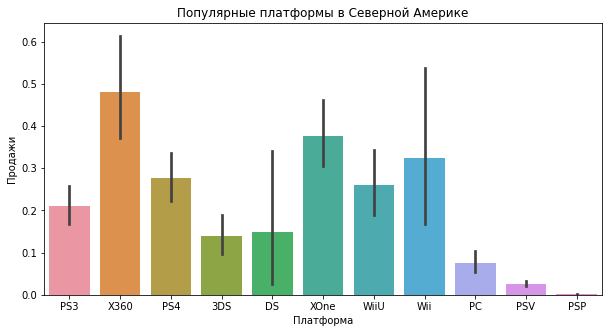

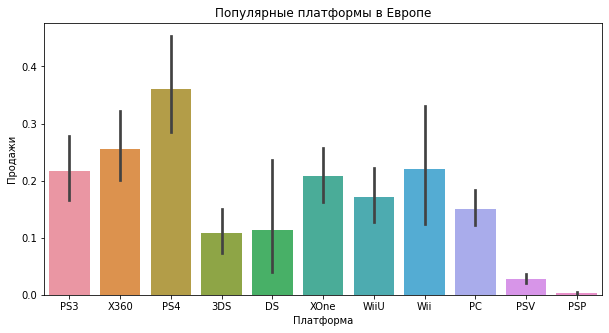

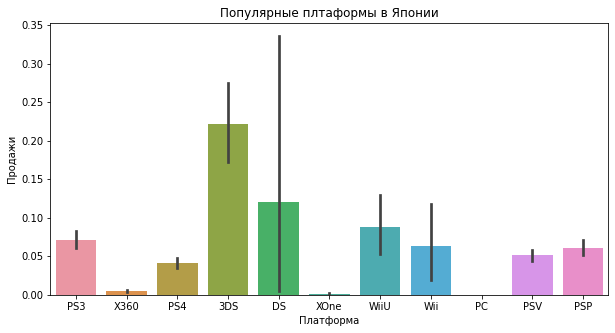

In [31]:
#рассмотрим самые популярные платформы по регионам:

#Северная Америка
plt.figure(figsize=(10,5))
sns.barplot(data=data_actual, x='platform', y='na_sales')
plt.title('Популярные платформы в Северной Америке')
plt.xlabel('Платформа')
plt.ylabel('Продажи');
plt.show()

#Европа
plt.figure(figsize=(10,5))
sns.barplot(data=data_actual, x='platform', y='eu_sales')
plt.title('Популярные платформы в Европе')
plt.xlabel('Платформа')
plt.ylabel('Продажи');
plt.show()

#Япония
plt.figure(figsize=(10,5))
sns.barplot(data=data_actual, x='platform', y='jp_sales')
plt.title('Популярные плтаформы в Японии')
plt.xlabel('Платформа')
plt.ylabel('Продажи');
plt.show()

Из графиков видно, что продажи в разных регионах различаются:
* в Северной Америке наиболее популярны игры на X360, XOne и Wii.
* в Европе лидер продаж - PS4. Помимо него популярен X360, а также PS3, XOne и Wii. 
* в Японии наибольшим спросом пользуется 3DS, остальные платформы получают сравнительно небольшое количество продаж.

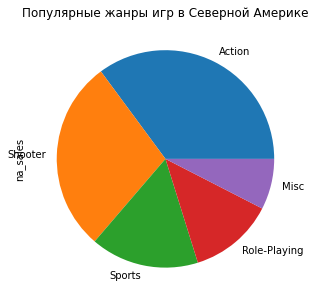

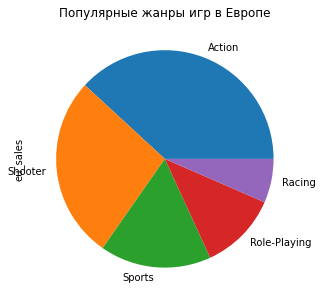

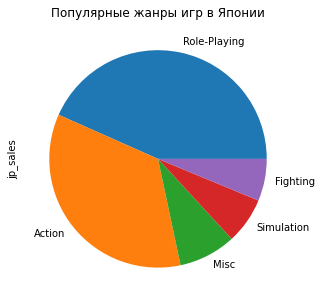

In [32]:
#рассмотрим самые популярные жанры в топ-5 платформах по регионам:

#Северная Америка
na_top_genres = data_actual.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head()
na_top_genres.plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title('Популярные жанры игр в Северной Америке');
#plt.figure(figsize=(12,5))
#sns.barplot(data=data_actual, x='genre', y='na_sales')
#plt.title('Популярные жанры игр в Северной Америке')
#plt.xlabel('Жанр игры')
#plt.ylabel('Продажи');
plt.show()

#Европа
na_top_genres = data_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head()
na_top_genres.plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title('Популярные жанры игр в Европе');
#plt.figure(figsize=(12,5))
#sns.barplot(data=data_actual, x='genre', y='eu_sales')
#plt.title('Популярные игры в Европе')
#plt.xlabel('Жанр игры')
#plt.ylabel('Продажи');
plt.show()

#Япония
na_top_genres = data_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head()
na_top_genres.plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title('Популярные жанры игр в Японии');
#plt.figure(figsize=(12,5))
#sns.barplot(data=data_actual, x='genre', y='jp_sales')
#plt.title('Популярные игры в Японии')
#plt.xlabel('Жанр игры')
#plt.ylabel('Продажи');
#plt.show()

В Северной Америке и Европе самые продаваемые жанры в основном схожи: наиболее популярны жанры Shooter и Action. В Японии картина другая: здесь наиболее популярны игры Role-Playing и Action.

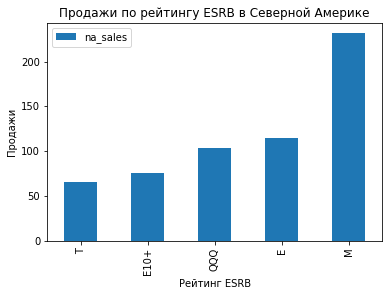

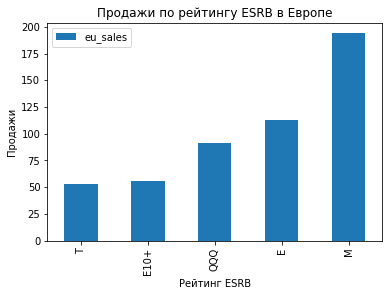

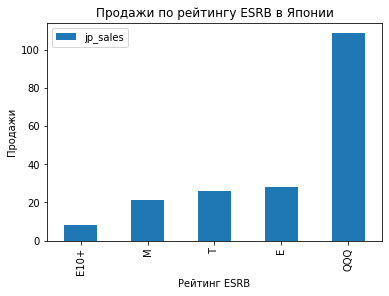

In [33]:
#рассмотрим влияние рейтинга ESRB на продажи в каждом регионе

#Северная Америка
na_esrb=data_actual.pivot_table(
    index='rating',
    values='na_sales',
    aggfunc=('sum')).sort_values(by='na_sales')
na_esrb.plot(kind='bar')
plt.title('Продажи по рейтингу ESRB в Северной Америке')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи')
plt.show()

#Европа
eu_esrb=data_actual.pivot_table(
    index='rating',
    values='eu_sales',
    aggfunc=('sum')).sort_values(by='eu_sales')
eu_esrb.plot(kind='bar')
plt.title('Продажи по рейтингу ESRB в Европе')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи')
plt.show()

#Япония
jp_esrb=data_actual.pivot_table(
    index='rating',
    values='jp_sales',
    aggfunc=('sum')).sort_values(by='jp_sales')
jp_esrb.plot(kind='bar')
plt.title('Продажи по рейтингу ESRB в Японии')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи')
plt.show()

В последние 5 лет в Северной Америке и Европе наиболее попуряны игры с рейтингом М (для взрослых). На втором месте - с рейтингом Е (для всех). В Японии больше всего продаж игр без рейтинга ESRB.

In [34]:
# Комментарий ревьюера
temp = data_actual.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

0 0.0


QQQ     1275
M        498
T        412
E        395
E10+     306
Name: rating, dtype: int64

**Выводы**
* Портрет покупателя в разных регионах различается.
* Покупатели из Северной Америки предпочитают играть на X360, XOne и Wii. Самые популярные жанры здесь - Shooter и Action. Наибольшую популярность имеют игры с рейтингом М (для взрослях), на втором месте - рейтинг Е (для всех).
* Покупатели из Европы в основном играют на PS4. Кроме нее неплохие продажи игр на платформах X360, а также PS3, XOne и Wii. Самые популярные жанры здесь - Shooter и Action. Хотя рейтинг ESRB для данного региона не используется, все же наибольшую популярность имеют игры с рейтингом М (для взрослях), на втором месте - рейтинг Е (для всех).
* Большая часть покупателей из Японии играют на 3DS, продажи по остальным платформам не очень большие. Самые популярные жанры игр в Японии - Role-Playing и Action. Больше всего здесь продаж игр без указания возрастного рейтинга (он не используется в данном регионе).

# Проверка гипотез <a name="hypothesis"></a>

Сформулируем проверяемую гипотезу и альтернативную гипотезу:

* Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
* Альтернативная гипотеза: пользовательские рейтинги платформ Xbox One и PC различаются.

In [35]:
#создадим переменные с пользовательскими рейтингами для обеих плтформ
xbox_rating = data_actual.query('platform == "X360"')
xbox_rating  = xbox_rating['user_score'].dropna()
pc_rating = data_actual.query('platform == "PC"')
pc_rating = pc_rating['user_score'].dropna()

#выполним проверку гипотезы. Значение alpha возьмем 0.05, как общепринятый критерий.
alpha = 0.05
results = st.ttest_ind(xbox_rating, pc_rating, equal_var=False)

display('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    display("Отвергаем нулевую гипотезу")
else:
    display("Не получилось отвергнуть нулевую гипотезу")

'p-значение:'

0.18105405842457592

'Не получилось отвергнуть нулевую гипотезу'

In [36]:
#средний пользовательский рейтинг для xbox:
xbox_rating.mean()

6.220851063829787

In [37]:
#средний пользовательский рейтинг для pc:
pc_rating.mean()

6.4286407766990274

С высокой вероятностью пользовательские рейтинги будут одинаковыми. Нулевую гипотезу отвергнуть не получилось.

Сформулируем следующую проверяемую гипотезу и альтернативнуй ей гипотезу:

* Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковые.
* Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports различаются.

In [38]:
#создадим переменные с пользовательскими рейтингами для обоих жанров:
action_rating = data_actual.query('genre == "Action"')
action_rating  = action_rating['user_score'].dropna()
sports_rating = data_actual.query('genre == "Sports"')
sports_rating = sports_rating['user_score'].dropna()

#выполним проверку гипотезы. Значение alpha возьмем 0.05, как общепринятый критерий.
alpha = 0.05
results = st.ttest_ind(action_rating, sports_rating, equal_var=False)

display('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    display("Отвергаем нулевую гипотезу")
else:
    display("Не получилось отвергнуть нулевую гипотезу")

'p-значение:'

4.24307776572644e-20

'Отвергаем нулевую гипотезу'

In [39]:
#средний пользовательский рейтинг для жанра Action:
action_rating.mean()

6.825047801147227

In [40]:
#средний пользовательский рейтинг для жанра Sports:
sports_rating.mean()

5.455897435897437

Вероятность получить одинаковые пользовательские рейтинги в жанрах Action и Sports стремится к нулю. Таким образом, нулевая гипотеза отвергается.

**Выводы**
* Гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, отвергнуть не получилось. С большой вероятностью оценки игр пользователями этих двух платформ будут одинаковыми или очень близкими друг к другу.
* Гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports одинаковые, отвергается - скорее всего оценки пользователей по этим жанрам будут различаться.

# Вывод <a name="conclusion"></a>

В ходе анализа данных за все периоды было выявлено, что:
* количество выпускаемых игр интенсивно росло с 2002 по 2008 годы. Далее начался спад, который продолжается и к 2016 году. Лидерами по продажам за весь период являются: PS2, X360, PS3, Wii, DS, PS.
* на 2016 год актуальны 9 платформ: Wii, X360, PS3, GBA, PS4, PC, Xone, WiiU и PSV. 
* срок жизни среди самых популярных платформ составляет около 10 лет. Основная часть продаж приходится на середину этого срока.

В ходе анализа данных за последние 5 лет было выявлено, что:
* оценки критиков слабо влияют на количество продаж - с увеличением оценки растут и продажи, но незначительно. Оценки пользователей никакого влияния на продажи не оказывают.
* самый продаваемый жанр игр за последние 5 лет - шутеры. На втором и третьем месте - игры жанров Platform и Sports. Хуже всего продаются приключения и стратегии.
* портрет покупателя в разных регионах различается.
* покупатели из Северной Америки предпочитают играть на X360, XOne и Wii. Самые популярные жанры здесь - Shooter, Platform и Sports. Наибольшую популярность имеют игры с рейтингом М (для взрослых), на втором месте - рейтинг Е (для всех).
* покупатели из Европы в основном играют на PS4. Кроме нее неплохие продажи игр на платформах X360, а также PS3, XOne и Wii. Самые популярные жанры здесь - Shooter, Platform, Sports и Racing. Наибольшую популярность имеют игры с рейтингом М (для взрослях), на втором месте - рейтинг Е (для всех).
* большая часть покупателей из Японии играют на 3DS, продажи по остальным платформам не очень большие. Самые популярные жанры игр в Японии - Role-Playing и Simulation. Больше всего в этом регионе продаются игры без указания возрастного рейтинга.

**Исходя из описанных выше выводов, предполагаю, что стратегию продаж на 2017 год стоит строить по-разному в разных регионах:**
* для Америки сделать упор на xbox 360 и игры жанров Shooter и Action. Стоит учесть рейтинг ESRB: лучше всего продаются игры с рейтингом М и Е.
* для Европы - на PS4 и игры жанров Shooter и Action. Можно учесть рейтинг ESRB: лучше всего продаются игры с рейтингом М и Е.
* для Японии - на 3DS и игры жанров Role-Playing и Action. Рейтинг ESRB здесь учитывать не стоит.
* отзывы об играх мало влияют на их продажи, поэтому можно не брать их в расчет.